# Constructing the Base Emission Model
Show how we chose which ions to include in our model, compute the emissivities for all ions, and show the computed AIA response function curves for the ions we chose.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import astropy.units as u

from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import EmissionModel, Element, list_elements

%matplotlib inline

## Build Emission Model

In [2]:
temperature = 10.**(np.arange(4.5,8,0.05))*u.K
density = np.logspace(7,11,15)/(u.cm**3)

In [9]:
selected_elements = [
                     'calcium',
                     'iron',
                     'magnesium',
                     'nickel',
                     'oxygen',
                     'silicon',
                     'sulfur'
]
ions = [Element(el, temperature, ion_kwargs={'abundance_filename': 'sun_coronal_1992_feldman'}) 
        for el in selected_elements]
em_model = EmissionModel(density, *ions)

## Calculate Emissivity

In [10]:
em_model.calculate_emissivity('/storage-home/w/wtb2/data/timelag_synthesis_v2/emissivity_table.h5',
                              notebook=True)

FloatProgress(value=0.0)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev600-py3.6.egg/synthesizAR/atomic/chianti.py:140: RuntimeWarning: invalid value encountered in greater
  ex_rate = u.Quantity(np.where(ex_rate > 0., ex_rate, 0.), u.cm**3/u.s).T


## Model AIA Response Functions
We want to make sure that our selected number of ions adequately "sample" the AIA response functions. If we included every ion in CHIANTI+continuum, we could compute them exactly, but this (as it turns out) is **very** computationally expensive.

In [11]:
aia = InstrumentSDOAIA([0,1]*u.s)

Calculate response by channel, including individual element components.

In [12]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em_model.temperature.shape+em_model.density.shape)
    components = {}
    for ion in em_model:
        wvl,emiss = em_model.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = scipy.interpolate.splev(wvl.value,channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value,response)
        ab = ion.abundance.value
        tmp *= ab*ion.ioneq.value[:,np.newaxis]/em_model.density.value/4./np.pi
        counts += tmp
        if ion.element_name in components:
            components[ion.element_name] += tmp
        else:
            components[ion.element_name] = tmp
    calc_temp_response[channel['name']] = counts
    calc_temp_response[f'{channel["name"]}_components'] = components

We want to evaluate the responses at constant pressure of $p=1\times10^{15}$ K/cm$^{3}$

In [13]:
const_p_indices = np.array([(i,np.argmin(np.fabs(em_model.density.value-d.value))) 
                            for i,d in enumerate(1e15/em_model.temperature)])

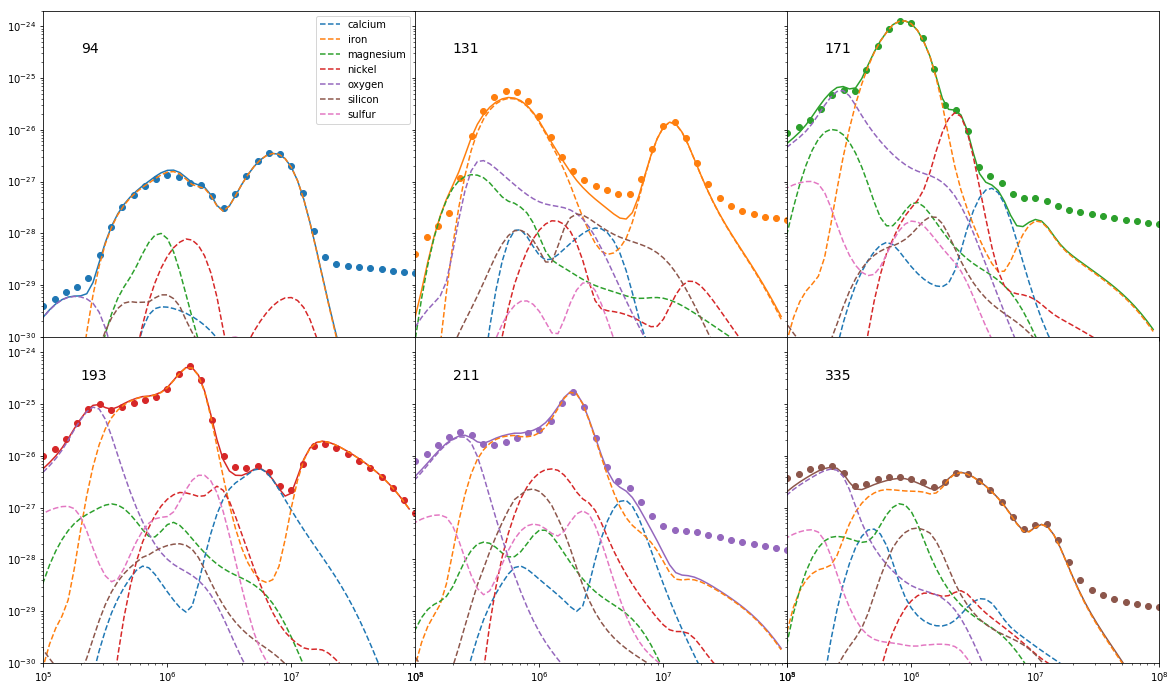

In [14]:
fig,axes = plt.subplots(2,3,figsize=(20,12),sharex=True,sharey=True)
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(data_temperature,channel['temperature_response_spline'])
    ax.plot(data_temperature,real_response,
            'o',markevery=3,color=f'C{i}')
    ax.plot(em_model.temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
             color=f'C{i}',ls='-')
    for j,element in enumerate(calc_temp_response[f'{channel["name"]}_components']):
        ax.plot(em_model.temperature,
                calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
                color=f'C{j%10}',ls='--',label=element)
    if i==0:
        ax.legend()
    ax.text(2e5,3e-25,f'{channel["name"]}',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)

## Save Emission Model

In [15]:
em_model.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')